## MNIST Classification using BLSTM Keras 

In this notebook, I will be using bidirectional LSTM to classify handwrittend digits from the mnist dataset. The data is downloaded from Kaggle, this link of which is given below. 

https://www.kaggle.com/c/digit-recognizer/data

### Basic Imports 

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional, GlobalMaxPooling1D, Lambda, Concatenate, Dense
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\ambar\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading the Data

In [2]:
mnist_train = pd.read_csv('train.csv',dtype=np.float64)

In [3]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see the train dataset is just one large matrix of size (28*28) corresponds to the height and width of the image 

### Sepreating dependent and independent variables 

In [4]:
X_train = mnist_train.iloc[:,1:].values 

In [5]:
X_train.shape

(42000, 784)

In [6]:
y_train = mnist_train.iloc[:,0:1].values

In [7]:
y_train.shape # targets 

(42000, 1)

### Scaling data

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
sc = MinMaxScaler(feature_range=(0,1))

In [10]:
X_train = sc.fit_transform(X_train)

### Reshaping the Input 

The input must be reshaped into a 3-D tensor of shape (samples,time-step,features) before feeding into LSTM cell 

In [11]:
X_train = np.reshape(X_train,newshape=(-1,28,28))

In [12]:
X_train.shape

(42000, 28, 28)

28 corresponds to height and width of the image. 

Since it is impossible to know wheather to take height or width in the time axis, we will be taking them both alternatively. This will be clear as we go further in this notebook. 

### Constants 

In [13]:
seqence_length = 28 
lstm_units = 15 

### Building the Model 

In [14]:
input_ = Input(shape=(seqence_length,seqence_length))

### Case 1

Here, we consider height on the time axis. This means LSTM will treat the height as seqence_length and width as features. 

In [15]:
rnn_1 = Bidirectional(LSTM(lstm_units, return_sequences=True))
x1 = rnn_1(input_)

# GlobalMaxPooling1D is used to get the Maximum value from the sequence of length 28
# If not for GlobalMaxPooling1D, the value of last hidden state from the sequence will be passed on to the next layer

x1 = GlobalMaxPooling1D()(x1) 

### Case 2 

Here, we consider width on the time axis. This means LSTM will treat the width as seqence_length and height as features.

In [16]:
rnn_2 = Bidirectional(LSTM(lstm_units, return_sequences=True))

#### Custom layer 

In order to switch the time axis from height to width, it is enough to just transpose the input befor feeding it to lstm. The permuter layer does this for us. Note that we are just transposing the 2nd and 3rd axis, the 1st axis which are samples remain the same. 

In [17]:
permutor = Lambda(lambda t: K.permute_dimensions(t,pattern=(0,2,1)))

In [18]:
x2 = permutor(input_)
x2 = rnn_2(x2)
x2 = GlobalMaxPooling1D() (x2)

#### Concatenate

Now we have to concatenate the output from both rnn 

In [19]:
concatenator = Concatenate(axis=1) # Note that the Concatenation is along the time axis 
x = concatenator([x1,x2])

#### Final Dense layer

In [20]:
# 10 units corresponds to 10 classes 

output = Dense(10, activation='softmax')(x)

In [21]:
model = Model(inputs=input_, outputs=output)

#### Compile

In [22]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

### Train 

In [23]:
classifier = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.25)

Train on 31500 samples, validate on 10500 samples
Epoch 1/10
31500/31500 [==============================] - 9s 279us/step - loss: 1.3232 - acc: 0.6719 - val_loss: 0.5729 - val_acc: 0.8670
Epoch 2/10
31500/31500 [==============================] - 7s 223us/step - loss: 0.4150 - acc: 0.8997 - val_loss: 0.3228 - val_acc: 0.9136
Epoch 3/10
31500/31500 [==============================] - 7s 216us/step - loss: 0.2686 - acc: 0.9296 - val_loss: 0.2295 - val_acc: 0.9410
Epoch 4/10
31500/31500 [==============================] - 7s 215us/step - loss: 0.2098 - acc: 0.9429 - val_loss: 0.1906 - val_acc: 0.9470
Epoch 5/10
31500/31500 [==============================] - 7s 215us/step - loss: 0.1771 - acc: 0.9509 - val_loss: 0.1687 - val_acc: 0.9523
Epoch 6/10
31500/31500 [==============================] - 7s 219us/step - loss: 0.1552 - acc: 0.9564 - val_loss: 0.1618 - val_acc: 0.9524
Epoch 7/10
31500/31500 [==============================] - 7s 223us/step - loss: 0.1410 - acc: 0.9599 - val_loss: 0.1448 - 

### Plotting Loss

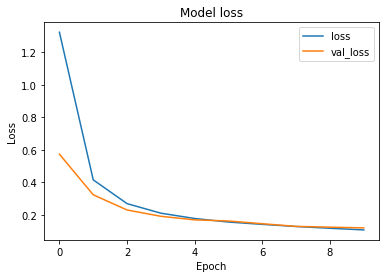

In [25]:
plt.plot(classifier.history['loss'],label='loss')
plt.plot(classifier.history['val_loss'],label='val_loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Plotting Accuracy 

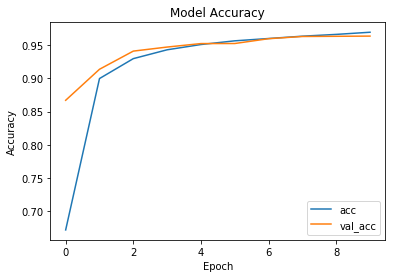

In [26]:
plt.plot(classifier.history['acc'],label='acc')
plt.plot(classifier.history['val_acc'],label='val_acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

As we can see this is a pretty good model. What's interesting here is that, it is not mandatory to use CNN on image 2-D image classification tasks all the time like wise it not madatory to LSTM on sequence classification taks all the time. These two architectures basically makes use of the strucutal composition of the data, so as long as we have a strucute to learn they both will do just fine. Yes, CNN's are obviously better for images and RNN's better for seqences but that does not really mean that they can only be exclusively used for such particular tasks. 